# 导入包

In [1]:
import os
import sys
import os
import time
import matplotlib.pyplot as plt
# import torch
import mindspore
# import torchvision
from data_loader import load_blender_data
from NeRF import get_rays
from NeRF import sample_points_from_rays
from NeRF import positional_encoding
from NeRF import TinyNeRF
from NeRF import volume_rendering
from NeRF import train
# from NeRF import tinynerf_step_forward
import numpy as np
# from NeRF import tinynerf_step_forward
from NeRF import get_minibatches
from tqdm import tqdm_notebook as tqdm
import imageio
from IPython.display import HTML
from base64 import b64encode

In [2]:
# seed = 9458
# mindspore.set_seed(seed)

In [3]:
# --mindspore 会根据设备自动设置上下文环境
# if torch.cuda.is_available():
#     print("GPU")
#     DEVICE = torch.device("cuda")
# else:
#     print("Using CPU!!")
#     DEVICE = torch.device("cpu")

import argparse
from mindspore import context

# 设置静态图模式
# mindspore.set_context(mode=mindspore.GRAPH_MODE)
mindspore.set_context(mode=mindspore.PYNATIVE_MODE)

##device_target根据脚本信息（--device_target）配置硬件信息；mode设置运行模式(动静态图模式)
context.set_context(device_target="GPU")
DTYPE = mindspore.float32

In [4]:
# 加载 NeRF 所需的数据
dataset_path = "./"
LEGO_DIR = os.path.join(dataset_path, "data", "nerf_synthetic", "lego")
print("Base_dir is :",LEGO_DIR)

Base_dir is : ./data/nerf_synthetic/lego


In [5]:
dev_res = 2
skip = 4

In [6]:
# 加载数据集
images, poses, hwf, i_split = load_blender_data(LEGO_DIR, dev_res, skip)
H, W, focal_length = hwf
# ----- 11.29 22：26
ray_origins, ray_directions = get_rays(H, W, focal_length, poses[1])
print(ray_origins.shape, ray_directions.shape)
print(ray_origins, ray_origins.dtype)
print(ray_directions[0][1])

Images shape:  (175, 400, 400, 4)
Poses shape:  (175, 4, 4)
(400, 400, 3) (400, 400, 3)
[[[-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  ...
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]]

 [[-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  ...
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]]

 [[-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  ...
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]]

 ...

 [[-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  ...
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498  1.2888215]
  [-1.3986591  3.5542498 

In [7]:
num_samples = 4
near_point = 2
far_point = 6

In [8]:
sampled_points, depth_values = sample_points_from_rays(
                                 ray_origins,
                                 ray_directions,
                                 near_point=near_point,
                                 far_point=far_point,
                                 num_samples=num_samples,
                                 random=True
                               )
print(depth_values.shape)
print(sampled_points.shape)
print(sampled_points[0][0])

(400, 400, 4)
(400, 400, 4, 3)
[[ 0.27683628  1.5713071   1.3383095 ]
 [ 1.4403743   0.19426394  1.3726761 ]
 [ 2.5866594  -1.1623602   1.4065332 ]
 [ 3.3258338  -2.037171    1.4283658 ]]


In [9]:
# 11.30 10:36
flattened_sampled_points = sampled_points.reshape((-1, 3))
pos_out = positional_encoding(flattened_sampled_points, 3)
pos_dim = pos_out.shape[-1]

In [10]:
# 11.30 15.14
model = TinyNeRF(pos_dim, fc_dim=128)
# 由于 mindspore 自动分析当前环境，所以不用转换数据
# model.cuda()

In [17]:
# 将所有的位姿经过一次 MLP，得到计算出的 RGB 和体密度，相当于做了一次初始化 (160000,21) -> (160000,4)
# # 11.30 21:13
# rgb_map, depth_map, acc_map = volume_rendering(radiance_field, ray_origins, depth_values)

# Near and far clipping distance
near_point = 2
far_point = 6

In [18]:
# Encoder definition, we use positional encoding
freq = 6
include_input = True
encoder = lambda x: positional_encoding(x, include_input=include_input, freq=freq)
enc_dim = (include_input + 2 *freq) * 3

In [19]:
# Define a tinynerf model, feel free to change the `fc_dim`
model = TinyNeRF(enc_dim, fc_dim=128)

In [20]:
# 训练
# Number of depth samples along each ray.
num_depth_samples_per_ray = 4
num_iters = 20000

In [21]:
# 尝试 12.1 10：57
# 构建训练函数

In [22]:
# Instantiate loss function and optimizer
# loss_fn = mindspore.nn.CrossEntropyLoss()
# lr = 5e-3
# optimizer = mindspore.nn.Adam(params=model.trainable_params(),learning_rate=lr)
images = mindspore.Tensor(images,dtype=mindspore.float32)
poses = mindspore.Tensor(poses,dtype=mindspore.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


psnr = 0.83874196
[0.8387419581413269]


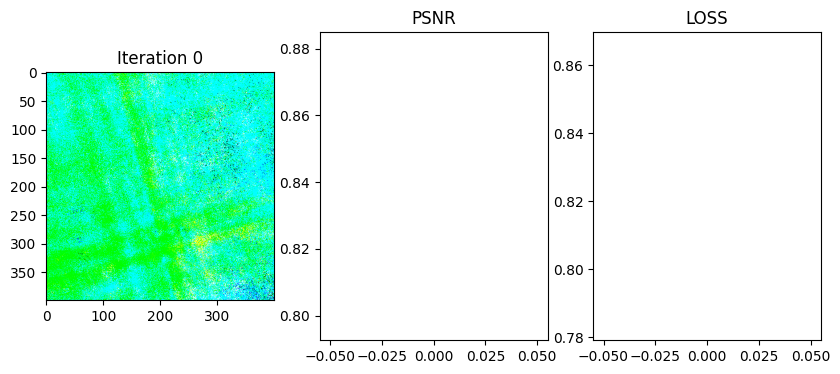

iter= 0
loss= 0.8166909
iter= 1
loss= 0.5332086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


psnr = 4.8988075
[0.8387419581413269, 4.898807525634766]


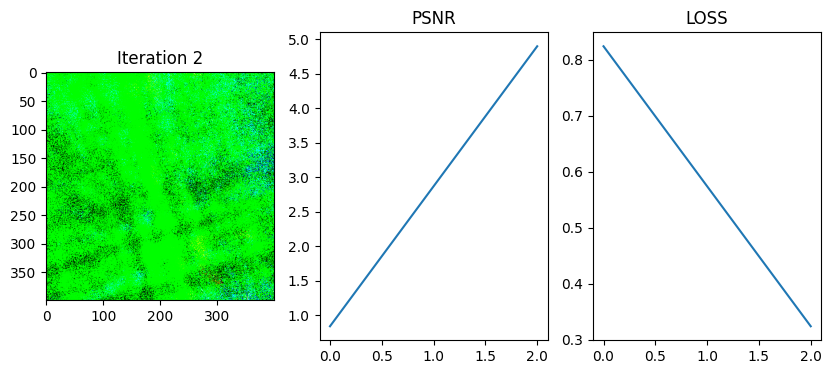

iter= 2
loss= 0.34147647
iter= 3
loss= 0.21910849


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


psnr = 8.112229
[0.8387419581413269, 4.898807525634766, 8.112229347229004]


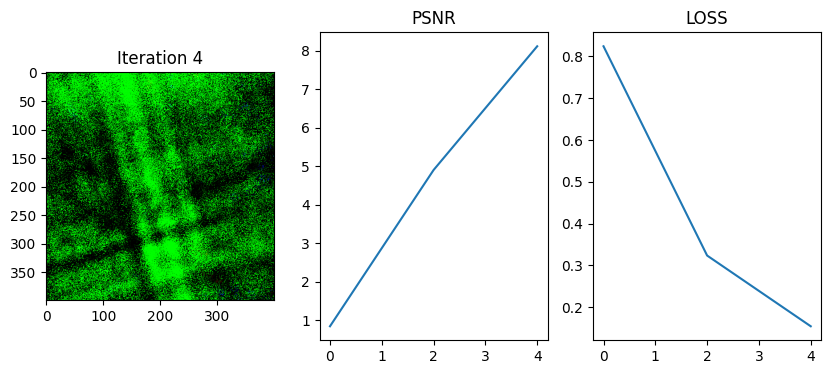

iter= 4
loss= 0.16174431
iter= 5
loss= 0.13462204
psnr = 10.247684
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545]


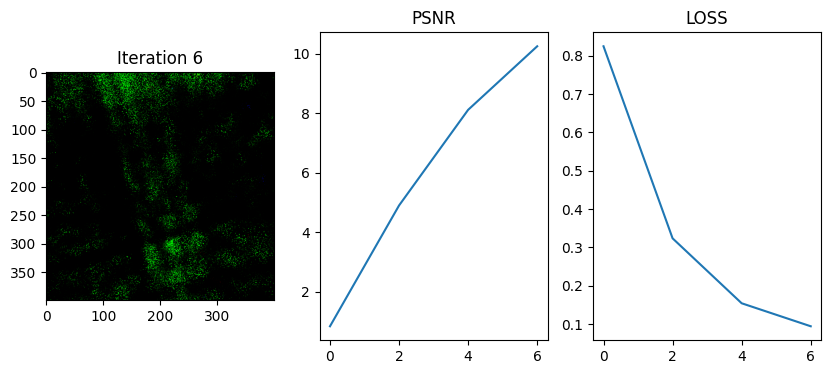

iter= 6
loss= 0.07223049
iter= 7
loss= 0.10961139
psnr = 10.330714
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043]


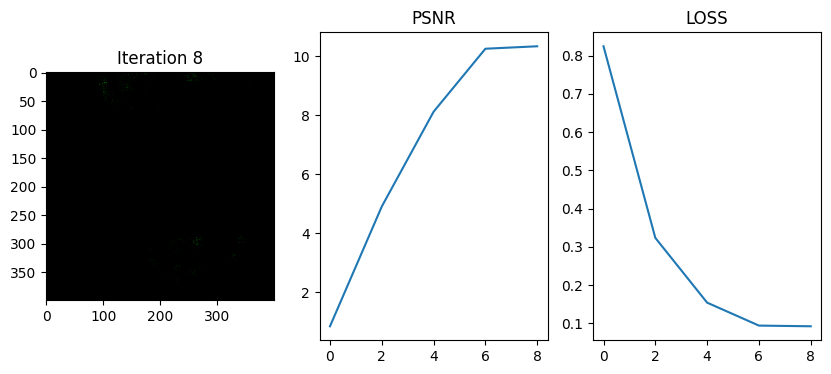

iter= 8
loss= 0.116996214
iter= 9
loss= 0.056493156
psnr = 10.328784
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637]


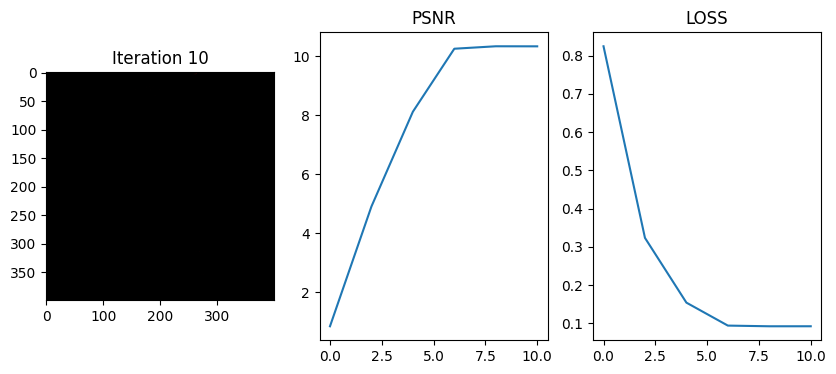

iter= 10
loss= 0.07041068
iter= 11
loss= 0.03576583
psnr = 10.328709
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164]


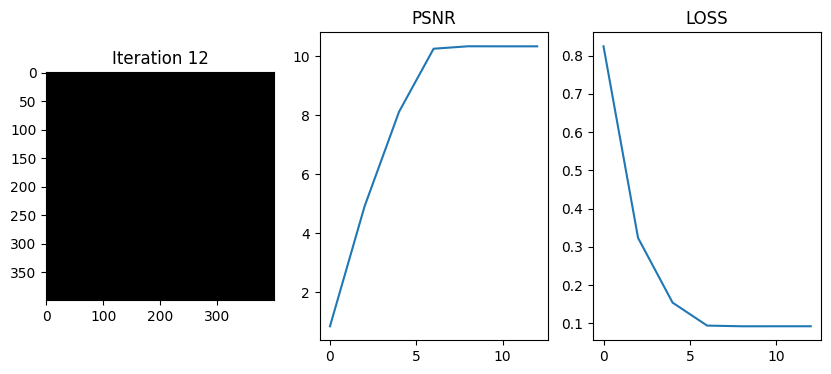

iter= 12
loss= 0.12902723
iter= 13
loss= 0.13175331
psnr = 10.328669
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352]


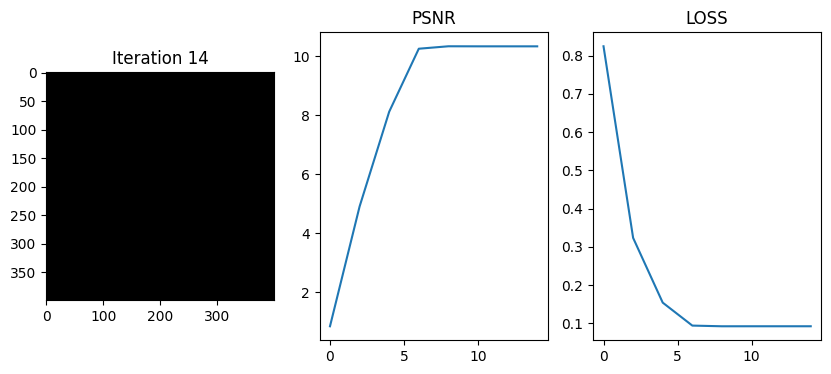

iter= 14
loss= 0.063581936
iter= 15
loss= 0.11593015
psnr = 10.328669
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352, 10.328668594360352]


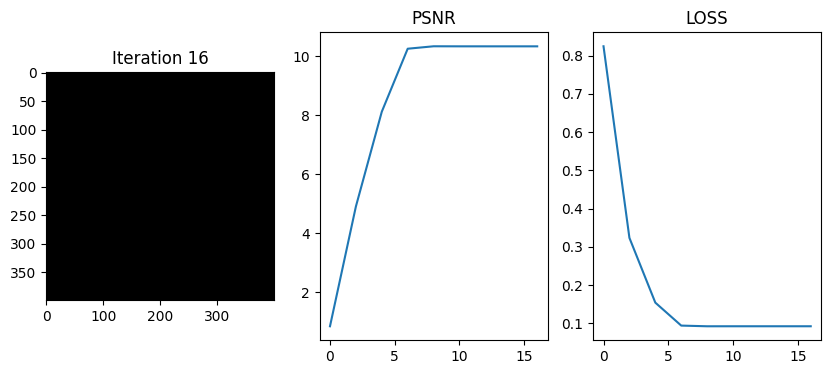

iter= 16
loss= 0.16021758
iter= 17
loss= 0.09113752
psnr = 10.328656
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352, 10.328668594360352, 10.328656196594238]


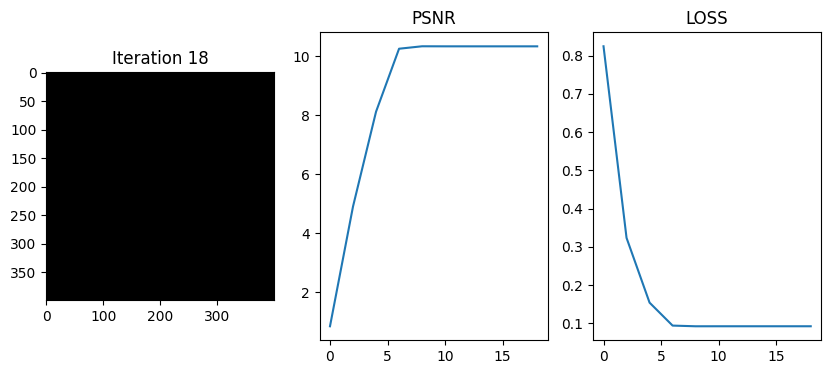

iter= 18
loss= 0.10427697
iter= 19
loss= 0.07378786
psnr = 10.328651
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352, 10.328668594360352, 10.328656196594238, 10.328651428222656]


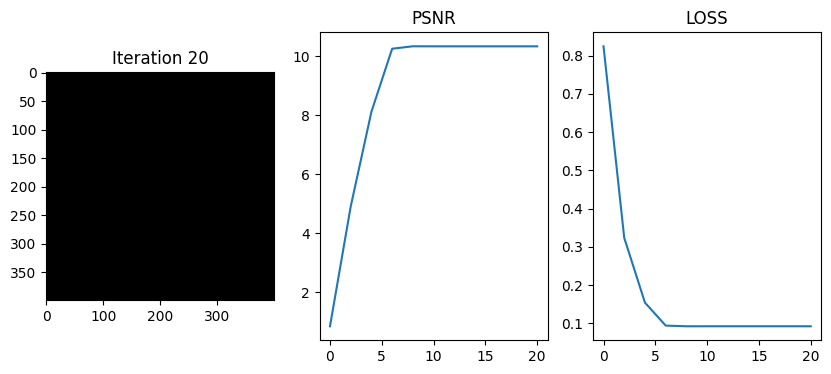

iter= 20
loss= 0.045329835
iter= 21
loss= 0.10695197
psnr = 10.328651
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352, 10.328668594360352, 10.328656196594238, 10.328651428222656, 10.328651428222656]


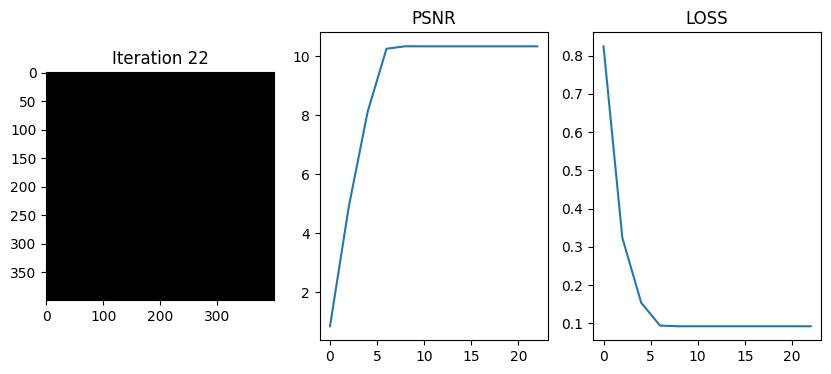

iter= 22
loss= 0.091503166
iter= 23
loss= 0.112967774
psnr = 10.328646
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352, 10.328668594360352, 10.328656196594238, 10.328651428222656, 10.328651428222656, 10.328645706176758]


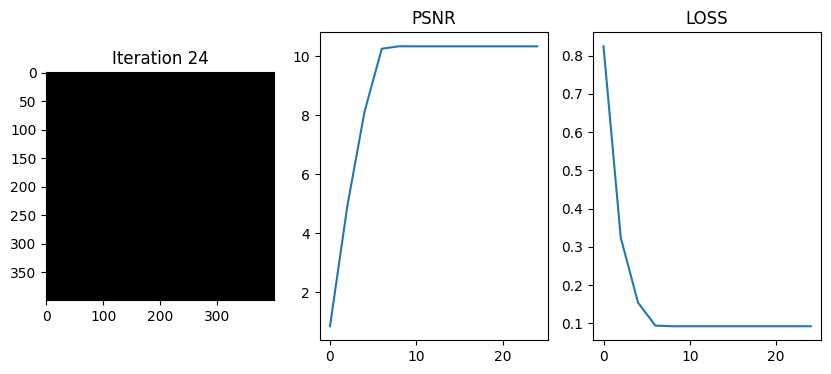

iter= 24
loss= 0.07949414
iter= 25
loss= 0.030360889
psnr = 10.328647
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352, 10.328668594360352, 10.328656196594238, 10.328651428222656, 10.328651428222656, 10.328645706176758, 10.328646659851074]


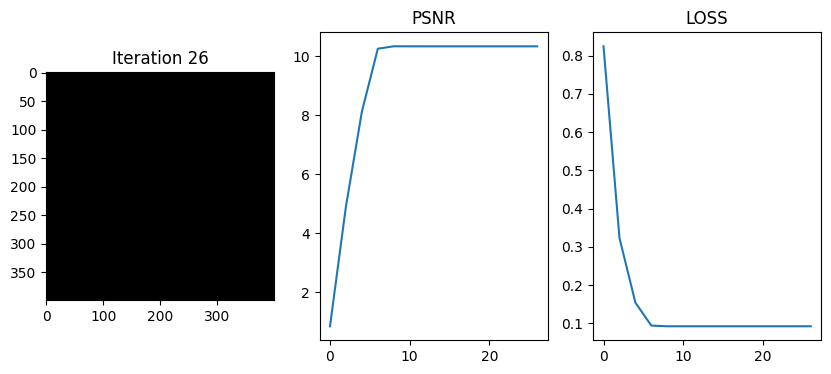

iter= 26
loss= 0.08043586
iter= 27
loss= 0.048555095
psnr = 10.328644
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352, 10.328668594360352, 10.328656196594238, 10.328651428222656, 10.328651428222656, 10.328645706176758, 10.328646659851074, 10.328643798828125]


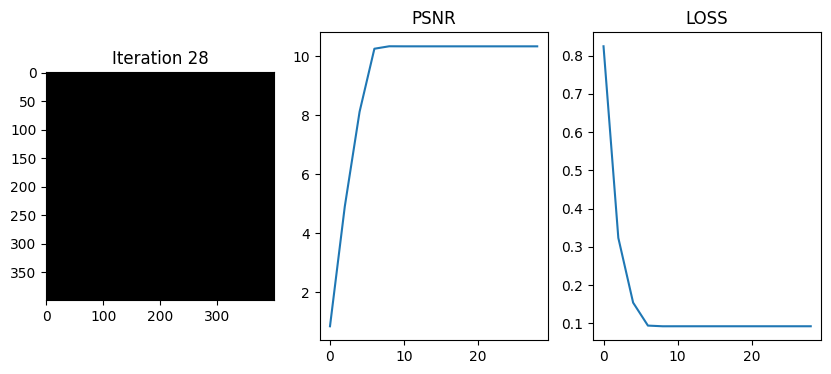

iter= 28
loss= 0.09040951
iter= 29
loss= 0.12463066
psnr = 10.328646
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352, 10.328668594360352, 10.328656196594238, 10.328651428222656, 10.328651428222656, 10.328645706176758, 10.328646659851074, 10.328643798828125, 10.328645706176758]


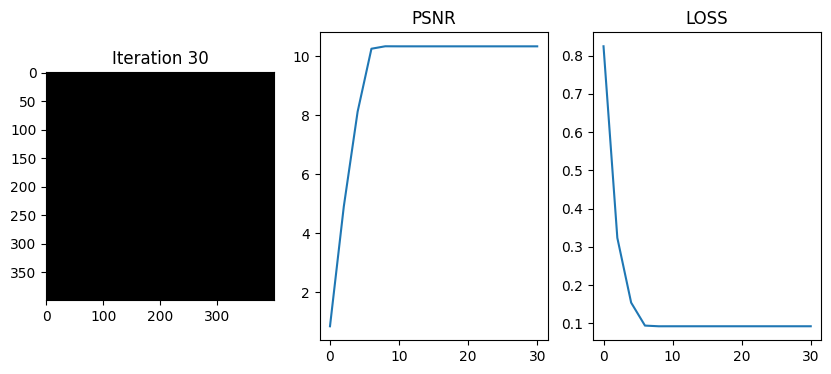

iter= 30
loss= 0.11101094
iter= 31
loss= 0.10834981
psnr = 10.328645
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352, 10.328668594360352, 10.328656196594238, 10.328651428222656, 10.328651428222656, 10.328645706176758, 10.328646659851074, 10.328643798828125, 10.328645706176758, 10.328644752502441]


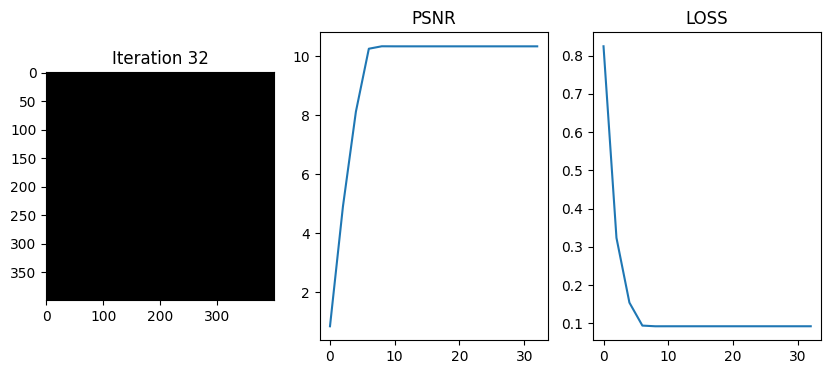

iter= 32
loss= 0.10868534
iter= 33
loss= 0.10834981
psnr = 10.328645
[0.8387419581413269, 4.898807525634766, 8.112229347229004, 10.24768352508545, 10.330714225769043, 10.328783988952637, 10.32870864868164, 10.328668594360352, 10.328668594360352, 10.328656196594238, 10.328651428222656, 10.328651428222656, 10.328645706176758, 10.328646659851074, 10.328643798828125, 10.328645706176758, 10.328644752502441, 10.328644752502441]


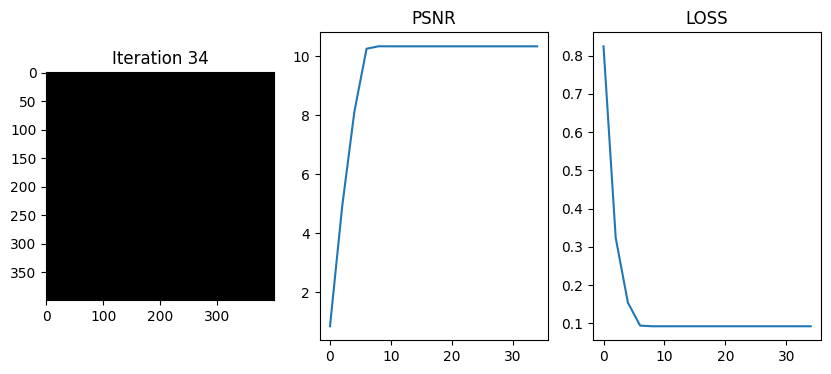

iter= 34
loss= 0.11489225
iter= 35


In [ ]:
train(images, poses, hwf, i_split, near_point,
      far_point, num_depth_samples_per_ray,
      num_iters, model)